Sentiment Analysis of Historical Text 

In [8]:
pip install --upgrade nltk


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Preprocessing and Data Cleaning

In [1]:
import re
import pdfplumber
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from docx import Document
import nltk
import pandas as pd

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Define a regex pattern for the date format
date_pattern = re.compile(r'(?:[A-Za-z]+, [A-Za-z]+ \d{1,2}, \d{4})')

# Function to insert newlines before and after each date in the text for better readability
def insert_newlines(text):
    # Add newlines before and after each date match
    text_with_newlines = date_pattern.sub(r'\n\n\n\g<0>\n', text)
    return text_with_newlines

# Function to preprocess text
def preprocess_text(text):
    # Normalize text
    text = text.lower()
    text = re.sub(r'(?<!\w)([A-Za-z])\s+', r'\1', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s\d]', '', text)

    # Tokenize text without stemming
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    return ' '.join(filtered_tokens)

# Read the PDF file using pdfplumber
def extract_text_from_pdf(pdf_path):
    text_content = []
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            text_content.append(page.extract_text())

    return ' '.join(text_content).replace('\n', ' ')


pdf_file_path = r'C:\Users\DELL\Desktop\Project\Untitled Folder\Anne-Frank-The-Diary-Of-A-Young-Girl.pdf'
output_word_file = 'Filtered_Anne-Frank-The-Diary-Of-A-Young-Girl.docx'

# Extract text from PDF
pdf_text = extract_text_from_pdf(pdf_file_path)

# Add newlines before and after dates
pdf_text_with_newlines = insert_newlines(pdf_text)

# Now preprocess text excluding the dates
# Split the text by newlines, preprocess non-date lines, and rejoin the text
processed_lines = [preprocess_text(line) for line in pdf_text_with_newlines.split('\n')]
preprocessed_text = '\n'.join(processed_lines)

# Data Integrity Checks
# Check for missing values, duplicates, and data types
df = pd.DataFrame({'Text': processed_lines})
missing_values = df.isnull().sum()
duplicates = df.duplicated().sum()
data_types = df.dtypes

# Create a Word document
doc = Document()
doc.add_paragraph(preprocessed_text)

# Save the Word document
doc.save(output_word_file)

print("Preprocessing complete. Output saved to", output_word_file)

# Print data integrity check results
print("\nData Integrity Checks:")
print("Missing values:")
print(missing_values)
print("\nDuplicates:", duplicates)
print("\nData types:")
print(data_types)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Preprocessing complete. Output saved to Filtered_Anne-Frank-The-Diary-Of-A-Young-Girl1.docx

Data Integrity Checks:
Missing values:
Text    0
dtype: int64

Duplicates: 344

Data types:
Text    object
dtype: object


 Emotion Extraction and Sentiment Analysis 

In [1]:
import csv
import docx
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Load the NRC Emotion Lexicon
nrc_lexicon_path = r'C:\Users\DELL\Desktop\Project\Untitled Folder\NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt'
nrc_lexicon = {}

with open(nrc_lexicon_path, "r") as file:
    for line in file:
        word, emotion, value = line.strip().split("\t")
        if word in nrc_lexicon:
            nrc_lexicon[word][emotion] = int(value)
        else:
            nrc_lexicon[word] = {emotion: int(value)}

# Function to preprocess text and extract emotions
def extract_emotions_from_text(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text.lower())
    preprocessed_tokens = [token for token in tokens if token.isalpha() and token not in stop_words]

    emotions = {'joy': set(), 'sadness': set(), 'anger': set(), 'fear': set(),
                'trust': set(), 'disgust': set(), 'surprise': set(), 'anticipation': set()}

    for word in preprocessed_tokens:
        if word in nrc_lexicon:
            emotions_found = nrc_lexicon[word]
            for emotion, sentiment in emotions_found.items():
                if sentiment == 1 and emotion in emotions:
                    emotions[emotion].add(word)

    return emotions

# Function to calculate sentiment score
def calculate_sentiment_score(emotions_data):
    positive_emotions = ['joy', 'trust', 'anticipation']
    negative_emotions = ['sadness', 'anger', 'fear', 'disgust']

    positive_score = sum(len(emotions_data[emotion]) for emotion in positive_emotions)
    negative_score = sum(len(emotions_data[emotion]) for emotion in negative_emotions)

    sentiment_score = positive_score - negative_score
    return sentiment_score

# Function to label sentiment based on sentiment score
def label_sentiment(sentiment_score):
    if sentiment_score > 10:
        return "Highly Positive"
    elif sentiment_score >= 1:
        return "Positive"
    elif sentiment_score == 0:
        return "Neutral"
    elif sentiment_score >= -10:
        return "Negative"
    else:
        return "Highly Negative"

# Function to find date pairs and extract emotions and words between them
def extract_emotions_between_date_pairs(diary_text):
    date_entries = re.findall(r"([A-Za-z]+day [A-Za-z]+ \d{1,2} \d{4})", diary_text)
    date_entries = [entry for entry in date_entries if not entry.startswith("today")]
    emotions_data_between_dates = []

    for i in range(len(date_entries) - 1):
        date1 = date_entries[i]
        date2 = date_entries[i + 1]

        # Find the text between two dates entries
        text_between_dates = re.search(f"{date1}(.+?){date2}", diary_text, re.DOTALL)

        if text_between_dates:
            text_between_dates = text_between_dates.group(1).strip()
            # Extract emotions from the text between dates
            emotions_data = extract_emotions_from_text(text_between_dates)
            if any(emotions_data.values()):
                # Calculate sentiment score
                sentiment_score = calculate_sentiment_score(emotions_data)

                # Label sentiment
                sentiment_label = label_sentiment(sentiment_score)
                emotions_data['Sentiment Score'] = sentiment_score
                emotions_data['Sentiment Label'] = sentiment_label

                # Append start and end dates to the emotions data
                emotions_data['Start Date'] = date1
                emotions_data['End Date'] = date2
                emotions_data_between_dates.append(emotions_data)

    # Check for "ANNE'S DIARY ENDS HERE" as the last entry
    last_entry_text = re.search(f"{date_entries[-1]}(.+)", diary_text, re.DOTALL)
    if last_entry_text:
        last_entry_text = last_entry_text.group(1).strip()
    
        emotions_data = extract_emotions_from_text(last_entry_text)
        if any(emotions_data.values()):
            sentiment_score = calculate_sentiment_score(emotions_data)
            sentiment_label = label_sentiment(sentiment_score)
            emotions_data['Sentiment Score'] = sentiment_score
            emotions_data['Sentiment Label'] = sentiment_label
            emotions_data['Start Date'] = date_entries[-1]
            emotions_data['End Date'] = "ANNE'S DIARY ENDS HERE"
            emotions_data_between_dates.append(emotions_data)

    return emotions_data_between_dates


docx_path = r'C:\Users\DELL\Desktop\Project\Untitled Folder\Filtered_Anne-Frank-The-Diary-Of-A-Young-Girl.docx'

# Read the diary text from the document
doc = docx.Document(docx_path)
diary_text = "\n".join([paragraph.text for paragraph in doc.paragraphs])

# Extract emotions between date pairs
emotions_between_dates = extract_emotions_between_date_pairs(diary_text)

# Specify the CSV file path
csv_file_path = 'emotions_between_dates_with_sentiment.csv'

# Write emotions data to CSV
with open(csv_file_path, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)

    # Write header
    header = ['Start Date', 'End Date', 'Joy Count', 'Joy Words', 'Sadness Count', 'Sadness Words',
              'Anger Count', 'Anger Words', 'Fear Count', 'Fear Words',
              'Trust Count', 'Trust Words', 'Disgust Count', 'Disgust Words',
              'Surprise Count', 'Surprise Words', 'Anticipation Count', 'Anticipation Words',
              'Sentiment Score', 'Sentiment Label']
    writer.writerow(header)

    # Write data rows
    for emotions_data in emotions_between_dates:
        row = [emotions_data['Start Date'], emotions_data['End Date']]
        for emotion_key in emotions_data.keys():
            if emotion_key not in ['Start Date', 'End Date', 'Sentiment Score', 'Sentiment Label']:
                count = len(emotions_data[emotion_key])
                distinct_words = ", ".join(emotions_data[emotion_key])
                row.extend([count, distinct_words])
        row.extend([emotions_data['Sentiment Score'], emotions_data['Sentiment Label']])
        writer.writerow(row)

print(f"Emotions data between date pairs with sentiment saved to {csv_file_path}")



Emotions data between date pairs with sentiment saved to emotions_between_dates_with_sentiment.csv


Visualization

C:\Users\DELL\AppData\Local\Temp\ipykernel_19608\742886052.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Start Date'] = pd.to_datetime(df['Start Date'], errors='coerce')


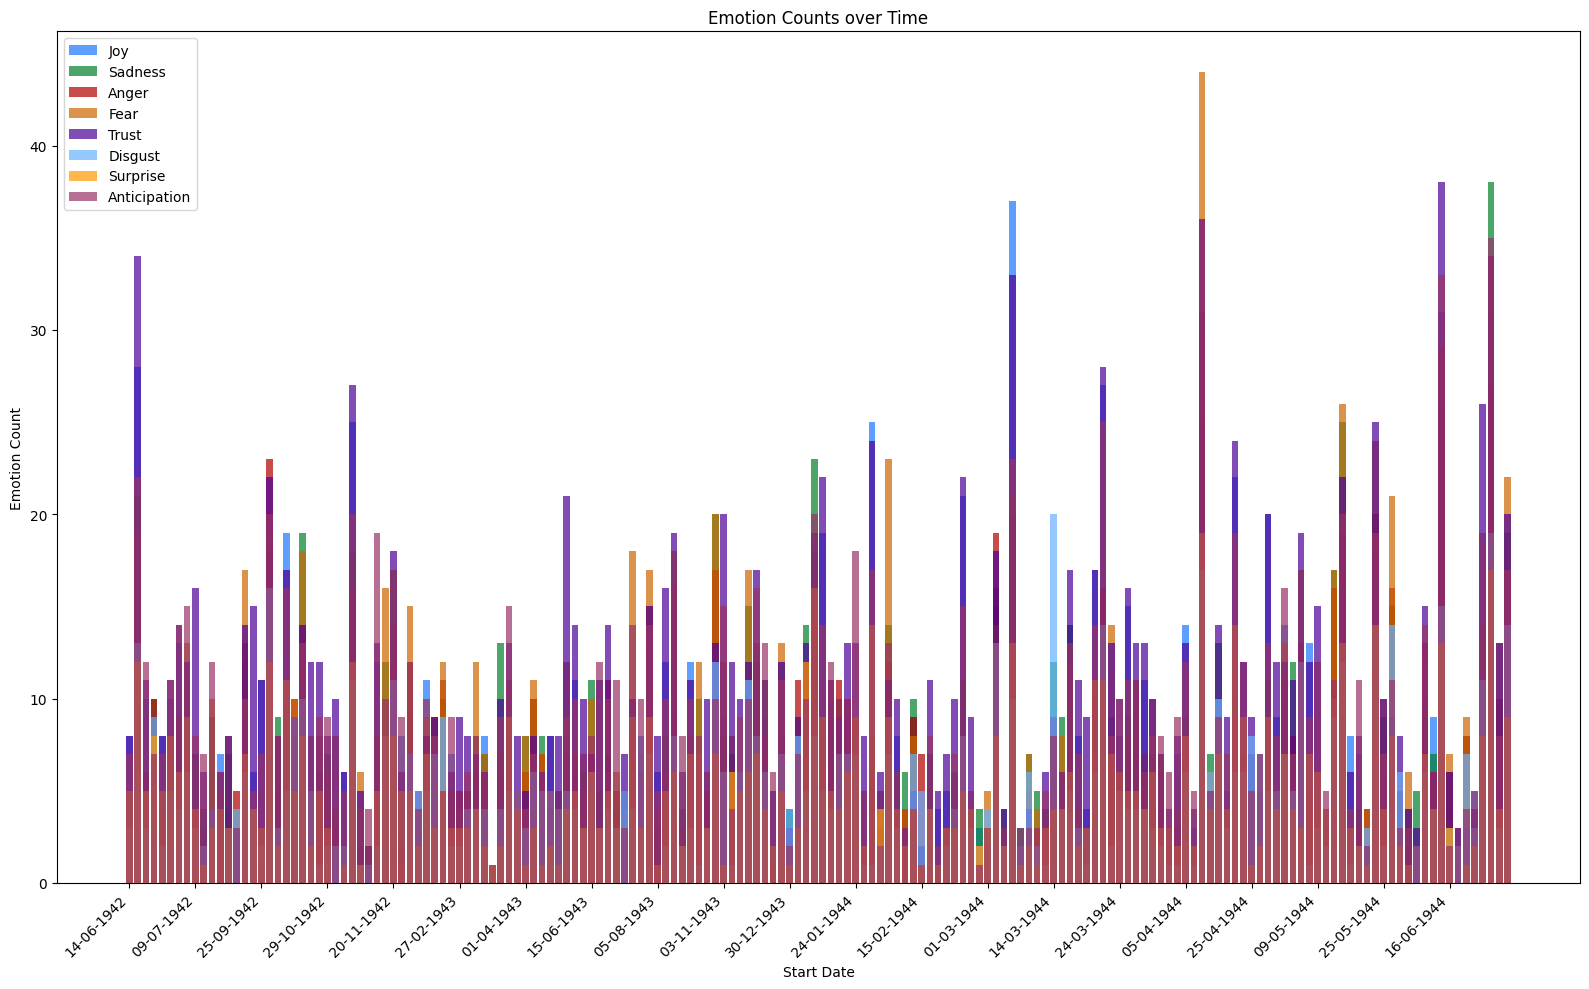

In [5]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

csv_file_path = r'C:\Users\DELL\Desktop\Project\Untitled Folder\emotions_between_dates_with_sentiment.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Convert 'Start Date' to datetime format
df['Start Date'] = pd.to_datetime(df['Start Date'], errors='coerce')

# Filter out rows with NaN dates
df = df.dropna(subset=['Start Date'])

# Plot a bar chart with x-axis ticks for selected dates and dark colors for each emotion
fig, ax = plt.subplots(figsize=(16, 10))  
emotions = ['Joy', 'Sadness', 'Anger', 'Fear', 'Trust', 'Disgust', 'Surprise', 'Anticipation']

# Define darker colors
colors = ['#1a75ff', '#00802b', '#b30000', '#cc6600', '#4d0099', '#66b2ff', '#ff9900', '#993366']

bar_width = 0.8  # Adjust the width of the bars
bar_space = 1.0  # Adjust the space between the bars

for i, (emotion, color) in enumerate(zip(emotions, colors)):
    positions = range(len(df['Start Date']))
    ax.bar(positions, df[f'{emotion} Count'], label=emotion, color=color, width=bar_width, alpha=0.7)

plt.xlabel('Start Date')
plt.ylabel('Emotion Count')
plt.title('Emotion Counts over Time')
plt.xticks(positions[::8], df['Start Date'][::8].dt.strftime('%d-%m-%Y'), rotation=45, ha='right')  # Set x-axis ticks every 8 positions
plt.legend()
plt.tight_layout()
plt.show()
